In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data

Data were loaded and cleaned. The texts were converted to lower case, and all punctuation marks were removed.

In [2]:
import string

titles = pd.read_csv("./data/medium_post_titles.csv")
titles.drop(columns=["subtitle", "subtitle_truncated_flag"], inplace=True)

titles.title = titles.title.str.replace('[{}]'.format(string.punctuation), '').str.lower()
titles.title = titles.title.str.replace('‘', '')
titles.title = titles.title.str.replace('’', '')
titles.title = titles.title.str.replace('“', '')
titles.title = titles.title.str.replace('”', '')
titles.title = titles.title.str.replace('—', '')

titles.head()

,category,title
0,work,21 conversations a fun and easy game for team...
1,spirituality,biblical porn at mars hill
2,lgbtqia,cisgender is that a disease
3,equality,call me nat love black cowboys and the frontie...
4,artificial-intelligence,can i train my model on your computer


20% of the data were held out as test set.

In [3]:
from sklearn.model_selection import train_test_split

titles_train, titles_test = train_test_split(titles, train_size=0.8, stratify=titles.category.values)

X_train = titles_train.title.str.split().tolist()
X_test = titles_test.title.str.split().tolist()

y_train = titles_train.category.values
y_test = titles_test.category.values

Categorical labels were converted to one-hot vector representations.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

integer_encoder = LabelEncoder()
integer_train = integer_encoder.fit_transform(y_train).reshape((-1, 1))
integer_test = integer_encoder.transform(y_test).reshape((-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
onehot_train = onehot_encoder.fit_transform(integer_train)
onehot_test = onehot_encoder.transform(integer_test)

The continuous bag-of-words model was used to generate Word2vec embeddings. The continuous bag-of-words method trains a network that can predict the target word given the contextual words around it in the corpus. Word2vec project each word into a high-dimension vector space where contextually close words are located spatially closely.

Here, individual words, which appeared more than (including) twice in the data in the training set, were mapped to 128-dimension vectors, while the algorithm utilized the 8 words around it in the text as the context. We then coverted the titles in both the training and test sets to sequences of vectors where each vector represents a word. Novel words that were not included in the vocabulary during training were mapped to a vector with all elements equal to 0.

As the titles were not of equal length, padding was needed. All titles were pre-padded with vectors where all elements are set to 0 so they all have the same length in the final vector-sequence representations.

In [6]:
from itertools import chain

def extractVocabulary(titles, min_count):
    
    flatten_titles = list(chain(*titles))
    
    vocabulary, counts = np.unique(flatten_titles, return_counts=True)
    vocabulary = vocabulary[counts >= 2]
    
    return vocabulary

In [7]:
from gensim.sklearn_api import W2VTransformer

vectorLength = 512
vectorizer = W2VTransformer(size=vectorLength, window=3, min_count=2, null_word=1, workers=-2, iter=2500)
vectorizer.fit(X_train)
vocabulary = extractVocabulary(X_train, 2)

In [8]:
def mapTitle2Vectors(title, vectorizer, vocabulary, vectorSize, maxLength):
    
    vectorsMatrix = np.zeros((maxLength, vectorSize))
    nWords = len(title)
    prePadLength = maxLength - nWords
    for i, word in enumerate(title):
        if word in vocabulary:
            vectorsMatrix[prePadLength + i, :] = vectorizer.transform(word)
            
    return vectorsMatrix

In [9]:
from multiprocessing import Pool
from multiprocessing import cpu_count
from functools import partial

def mapTitles2Vectors(titles, vectorizer, vocabulary, vectorSize, maxLength):
    
    pool = Pool(cpu_count() - 1)
    
#     nTitles = len(titles)
    
#     representations = [[] for i in range(nTitles)]
#     for i, title in tqdm(enumerate(titles)):
#         representations[i] = mapTitle2Vectors(title, vectorizer, vocabulary, vectorSize, maxLength)
    
    mapTitle2Vectors_partial = partial(mapTitle2Vectors, vectorizer=vectorizer, vocabulary=vocabulary, vectorSize=vectorSize, maxLength=maxLength)
    representations = pool.map(mapTitle2Vectors_partial, titles)
    
    return np.concatenate(list(map(lambda mat: mat[np.newaxis, :], representations)), axis=0)

In [10]:
maxTitleLength = max(map(len, X_train + X_test))
vectors_train = mapTitles2Vectors(X_train, vectorizer, vocabulary, vectorLength, maxTitleLength)
vectors_test = mapTitles2Vectors(X_test, vectorizer, vocabulary, vectorLength, maxTitleLength)

# LSTM neural network

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from time import time

lstmLayer = LSTM(512, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(512, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier = Sequential([lstmLayer, fullyConnectedLayer1, fullyConnectedLayer2])
classifier.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("new_LSTM_best_model.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history = classifier.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier = load_model("new_LSTM_best_model.h5")

_, train_accuracy = classifier.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

Using TensorFlow backend.
W1009 16:54:28.786300 4584838592 deprecation_wrapper.py:119] From /anaconda3/envs/SpringBoard/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1009 16:54:28.821155 4584838592 deprecation_wrapper.py:119] From /anaconda3/envs/SpringBoard/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1009 16:54:28.826083 4584838592 deprecation_wrapper.py:119] From /anaconda3/envs/SpringBoard/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1009 16:54:29.208794 4584838592 deprecation_wrapper.py:119] From /anaconda3/envs/SpringBoard/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Op

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 171s - loss: 4.2742 - acc: 0.0384 - val_loss: 4.1605 - val_acc: 0.0400

Epoch 00001: val_acc improved from -inf to 0.03999, saving model to new_LSTM_best_model.h5
Epoch 2/5000
 - 152s - loss: 4.1588 - acc: 0.0392 - val_loss: 4.1572 - val_acc: 0.0400

Epoch 00002: val_acc did not improve from 0.03999
Epoch 3/5000
 - 152s - loss: 4.1583 - acc: 0.0400 - val_loss: 4.1573 - val_acc: 0.0400

Epoch 00003: val_acc did not improve from 0.03999
Epoch 4/5000
 - 154s - loss: 4.1580 - acc: 0.0399 - val_loss: 4.1579 - val_acc: 0.0401

Epoch 00004: val_acc improved from 0.03999 to 0.04010, saving model to new_LSTM_best_model.h5
Epoch 5/5000
 - 152s - loss: 4.1579 - acc: 0.0403 - val_loss: 4.1565 - val_acc: 0.0380

Epoch 00005: val_acc did not improve from 0.04010
Epoch 6/5000
 - 152s - loss: 4.1572 - acc: 0.0399 - val_loss: 4.1560 - val_acc: 0.0401

Epoch 00006: val_acc did not improve from 0.04010
Epoch 7/5000
 - 151s - loss: 4.1564 


Epoch 00050: val_acc improved from 0.19744 to 0.20377, saving model to new_LSTM_best_model.h5
Epoch 51/5000
 - 151s - loss: 3.2204 - acc: 0.2167 - val_loss: 3.3336 - val_acc: 0.2037

Epoch 00051: val_acc did not improve from 0.20377
Epoch 52/5000
 - 151s - loss: 3.2476 - acc: 0.2144 - val_loss: 3.3200 - val_acc: 0.2089

Epoch 00052: val_acc improved from 0.20377 to 0.20895, saving model to new_LSTM_best_model.h5
Epoch 53/5000
 - 152s - loss: 3.1992 - acc: 0.2219 - val_loss: 3.3052 - val_acc: 0.2123

Epoch 00053: val_acc improved from 0.20895 to 0.21227, saving model to new_LSTM_best_model.h5
Epoch 54/5000
 - 151s - loss: 3.1855 - acc: 0.2245 - val_loss: 3.2836 - val_acc: 0.2152

Epoch 00054: val_acc improved from 0.21227 to 0.21516, saving model to new_LSTM_best_model.h5
Epoch 55/5000
 - 151s - loss: 3.1711 - acc: 0.2272 - val_loss: 3.2994 - val_acc: 0.2127

Epoch 00055: val_acc did not improve from 0.21516
Epoch 56/5000
 - 152s - loss: 3.1624 - acc: 0.2294 - val_loss: 3.2683 - val_ac


Epoch 00103: val_acc improved from 0.27179 to 0.27223, saving model to new_LSTM_best_model.h5
Epoch 104/5000
 - 149s - loss: 2.6217 - acc: 0.3380 - val_loss: 3.1627 - val_acc: 0.2649

Epoch 00104: val_acc did not improve from 0.27223
Epoch 105/5000
 - 155s - loss: 2.6479 - acc: 0.3332 - val_loss: 3.0661 - val_acc: 0.2753

Epoch 00105: val_acc improved from 0.27223 to 0.27531, saving model to new_LSTM_best_model.h5
Epoch 106/5000
 - 159s - loss: 2.6058 - acc: 0.3412 - val_loss: 3.2335 - val_acc: 0.2630

Epoch 00106: val_acc did not improve from 0.27531
Epoch 107/5000
 - 151s - loss: 2.5997 - acc: 0.3430 - val_loss: 3.1262 - val_acc: 0.2744

Epoch 00107: val_acc did not improve from 0.27531
Epoch 108/5000
 - 151s - loss: 2.5859 - acc: 0.3471 - val_loss: 3.0612 - val_acc: 0.2773

Epoch 00108: val_acc improved from 0.27531 to 0.27725, saving model to new_LSTM_best_model.h5
Epoch 109/5000
 - 150s - loss: 2.5902 - acc: 0.3453 - val_loss: 3.0521 - val_acc: 0.2797

Epoch 00109: val_acc improv

 - 150s - loss: 2.1956 - acc: 0.4264 - val_loss: 3.5345 - val_acc: 0.2668

Epoch 00160: val_acc did not improve from 0.28658
Epoch 161/5000
 - 149s - loss: 2.2276 - acc: 0.4204 - val_loss: 3.1920 - val_acc: 0.2855

Epoch 00161: val_acc did not improve from 0.28658
Epoch 162/5000
 - 149s - loss: 2.2073 - acc: 0.4249 - val_loss: 3.2689 - val_acc: 0.2806

Epoch 00162: val_acc did not improve from 0.28658
Epoch 163/5000
 - 149s - loss: 2.1630 - acc: 0.4361 - val_loss: 3.3189 - val_acc: 0.2780

Epoch 00163: val_acc did not improve from 0.28658
Epoch 164/5000
 - 149s - loss: 2.1813 - acc: 0.4301 - val_loss: 3.3855 - val_acc: 0.2786

Epoch 00164: val_acc did not improve from 0.28658
Epoch 165/5000
 - 150s - loss: 2.1399 - acc: 0.4399 - val_loss: 3.3844 - val_acc: 0.2773

Epoch 00165: val_acc did not improve from 0.28658
Epoch 166/5000
 - 150s - loss: 2.1646 - acc: 0.4333 - val_loss: 3.1996 - val_acc: 0.2846

Epoch 00166: val_acc did not improve from 0.28658
Epoch 167/5000
 - 151s - loss: 2.16


Epoch 00218: val_acc did not improve from 0.28868
Epoch 219/5000
 - 147s - loss: 1.8704 - acc: 0.5014 - val_loss: 3.7547 - val_acc: 0.2722

Epoch 00219: val_acc did not improve from 0.28868
Epoch 220/5000
 - 147s - loss: 1.8673 - acc: 0.5018 - val_loss: 3.6598 - val_acc: 0.2689

Epoch 00220: val_acc did not improve from 0.28868
Epoch 221/5000
 - 146s - loss: 1.9031 - acc: 0.4923 - val_loss: 3.7483 - val_acc: 0.2690

Epoch 00221: val_acc did not improve from 0.28868
Epoch 222/5000
 - 147s - loss: 1.8698 - acc: 0.4999 - val_loss: 3.6542 - val_acc: 0.2774

Epoch 00222: val_acc did not improve from 0.28868
Epoch 00222: early stopping
Time elapsed during training: 33383.191151857376
Accuracy on training set: 0.4481084501756047
Accuracy on held-out test set: 0.28868058851447553


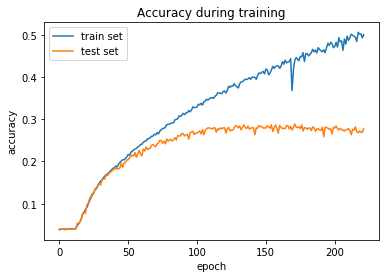

In [12]:
def plotFittingAccuracy(history):
    
    plt.plot(history.history['acc'], label='train set')
    plt.plot(history.history['val_acc'], label='test set')
    
    plt.title("Accuracy during training")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    
plotFittingAccuracy(history)

# Evaluation

In [13]:
def reveseOneHot(prediction_output):
    integer_encode = onehot_encoder.inverse_transform(prediction_output).flatten().astype(int)
    return integer_encoder.inverse_transform(integer_encode)

In [14]:
onehot_pred = classifier.predict(vectors_test)
y_pred = reveseOneHot(onehot_pred)

In [15]:
def plotConfusionMatrix(confusionMatrix, classes):
    
    confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
    
    heatmap_df = pd.DataFrame(confusionMatrix, index=classes, columns=classes)
    
    fig, ax = plt.subplots(figsize=(16,13))
    sns.heatmap(heatmap_df, xticklabels=True,yticklabels=True, ax=ax, vmin=0,vmax=1)
    ax.set_aspect("equal")
    plt.title("Confusion Matrix", fontsize=20)
    plt.ylabel("true category", fontsize=15)
    plt.xlabel("predicted category", fontsize=15)

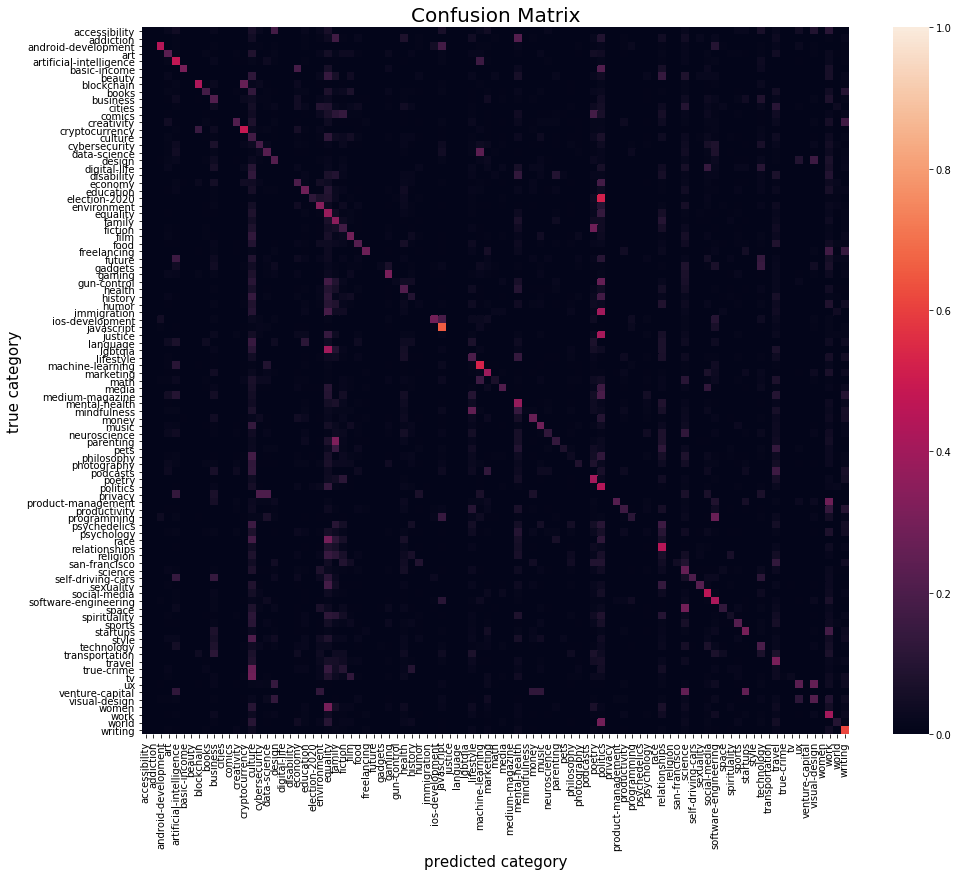

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

category_list = unique_labels(y_test, y_pred)

cMatrix = confusion_matrix(y_test, y_pred, labels=category_list)

plotConfusionMatrix(cMatrix, category_list)

In [17]:
def precisionFromConfusionMatrix(confusionMatrix):
    
    truePos = np.diagonal(confusionMatrix)
    falsePos = np.asarray(confusionMatrix.sum(axis=0)) - truePos
    
    precision = truePos / (truePos + falsePos)
    precision = precision[~np.isnan(precision)]
    
    return precision.mean()

precision = precisionFromConfusionMatrix(cMatrix)
print("Average multiclass precision: {}".format(precision))

Average multiclass precision: 0.26334439605682425
